In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

from fastai import *
from fastai.vision import *
import pandas as pd

import tarfile
import scipy.io
import numpy as np
import cv2
import os
import shutil
import random

from torchvision.models import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

import sys
import pretrainedmodels

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
path = Path('/home/amccarthy13/Documents/car-damage-dataset')

In [5]:
tfms = get_transforms(do_flip=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2,
                      xtra_tfms=[brightness(change=(0.5*(1-0.1), 0.5*(1+0.1)), p=0.75),
                                 contrast(scale=(1-0.1, 1/(1-0.1)), p=0.75)])

data1 = ImageDataBunch.from_folder(path/'data2a','training','validation',ds_tfms=tfms, bs=64, size=224).normalize(imagenet_stats)

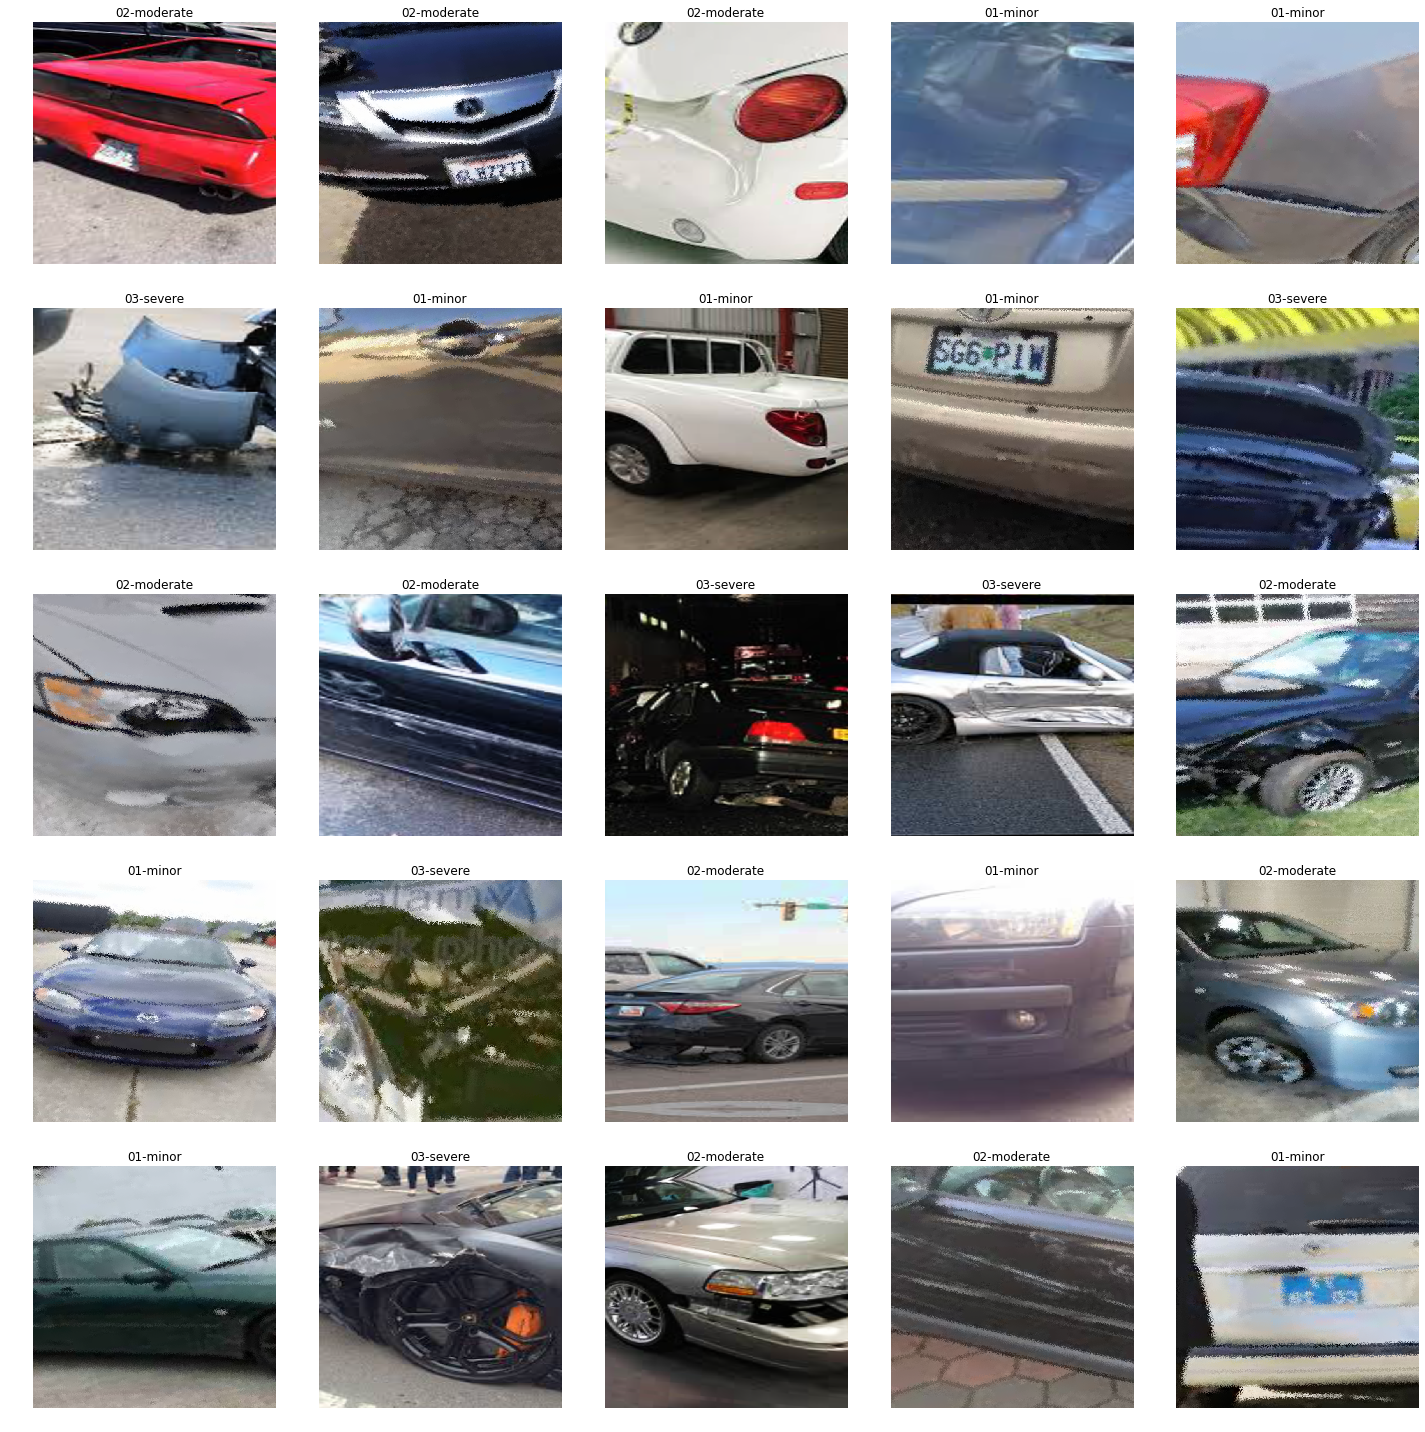

In [14]:
data1.show_batch()

In [4]:
print(len(data1.classes))
print(data1.classes)

3
['00-front', '01-rear', '02-side']


In [6]:
learn1 = create_cnn(data1, models.resnet152, pretrained=True, metrics=[error_rate, accuracy])
learn1.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


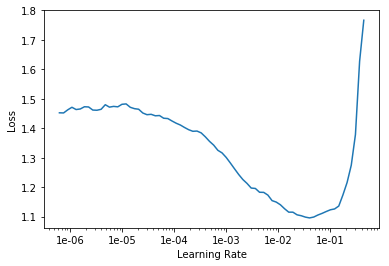

In [7]:
learn1.lr_find()
learn1.recorder.plot()

In [8]:
learn1.fit_one_cycle(10, slice(1e-3, 1e-2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


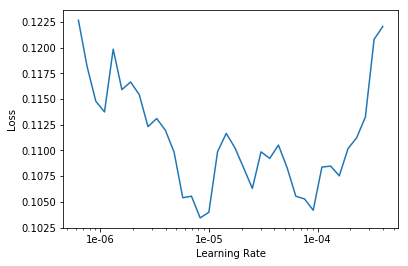

In [9]:
learn1.unfreeze()
learn1.lr_find()
learn1.recorder.plot()

In [10]:
learn1.fit_one_cycle(10, slice(1e-5, 1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


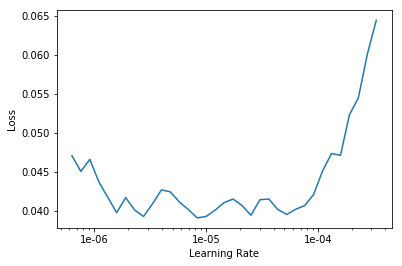

In [11]:
learn1.unfreeze()
learn1.lr_find()
learn1.recorder.plot()

In [12]:
learn1.fit_one_cycle(8, slice(1e-6, 1e-5))

In [13]:
log_preds, y = learn1.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8129)

# Heatmaps

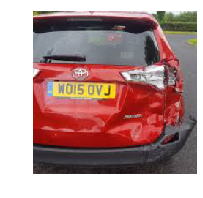

In [94]:
idx=79
x,y = data1.valid_ds[idx]
x.show()
data1.valid_ds.y[idx]

In [63]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [38]:
from fastai.callbacks.hooks import *

In [39]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [95]:
t = data1.valid_ds[79][0].data; t.shape

torch.Size([3, 224, 224])

In [96]:
t[None].shape

torch.Size([1, 3, 224, 224])

In [97]:
edge = F.conv2d(t[None], k)

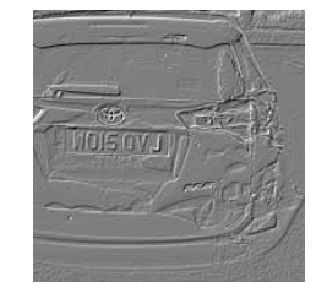

In [98]:
show_image(edge[0], figsize=(5,5));

In [102]:
m = learn1.model.eval();

In [103]:
xb,_ = data1.one_item(x)
xb_im = Image(data1.denorm(xb)[0])
xb = xb.cuda()

In [104]:
from fastai.callbacks.hooks import *

In [105]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [106]:
hook_a,hook_g = hooked_backward()

In [107]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 7, 7])

In [108]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [109]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

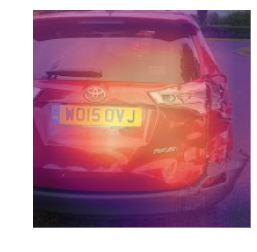

In [110]:
show_heatmap(avg_acts)

# Gradient Based Localization

In [111]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 7, 7]), torch.Size([2048]))

In [112]:
mult = (acts*grad_chan[...,None,None]).mean(0)

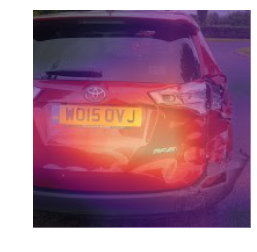

In [113]:
show_heatmap(mult)

In [114]:
hook_a,hook_g = hooked_backward(0)

In [115]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

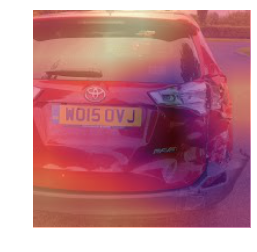

In [116]:
show_heatmap(mult)

# Plotting Loses

In [27]:
preds,y,losses = learn1.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn1, preds, y, losses)

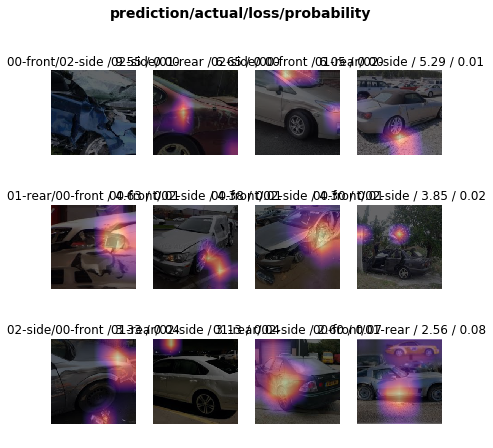

In [29]:
interp.plot_top_losses(12, figsize=(7,7))

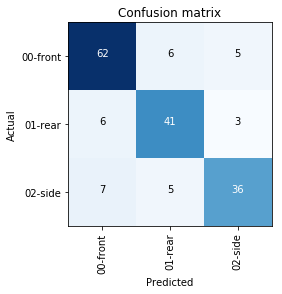

In [30]:
interp.plot_confusion_matrix()

In [24]:
data2 = ImageDataBunch.from_folder(path/'data2a','training','validation',ds_tfms=tfms, bs=64, size=400).normalize(imagenet_stats)
learn2 = create_cnn(data2, models.resnet50, pretrained=True, metrics=[error_rate, accuracy]).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


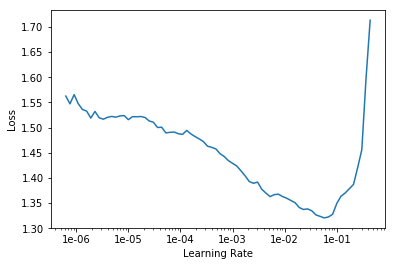

In [25]:
learn2.lr_find()
learn2.recorder.plot()

In [26]:
lr = 5e-3
learn2.fit_one_cycle(8, slice(lr))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


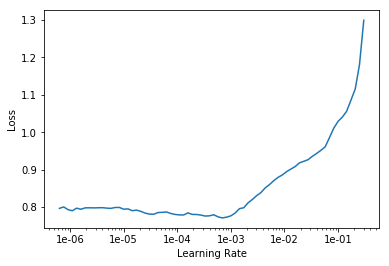

In [28]:
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [32]:
learn2.fit_one_cycle(8, slice(1e-4, 1e-3))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


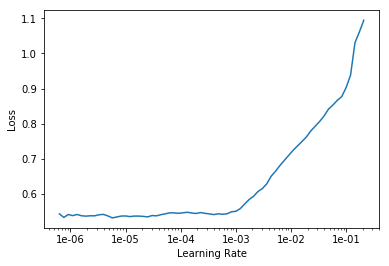

In [33]:
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [34]:
learn2.fit_one_cycle(8, slice(1e-5, 1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


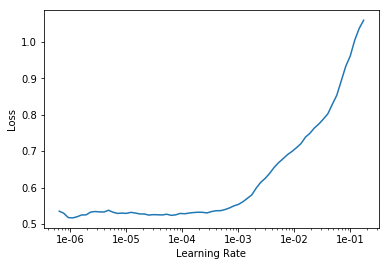

In [35]:
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [36]:
learn2.fit_one_cycle(8, slice(1e-6, 1e-5))

In [13]:
data3 = ImageDataBunch.from_folder(path/'data2a','training','validation',ds_tfms=tfms, bs=64, size=224).normalize(imagenet_stats)
learn3 = create_cnn(data3, models.resnet101, pretrained=True, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


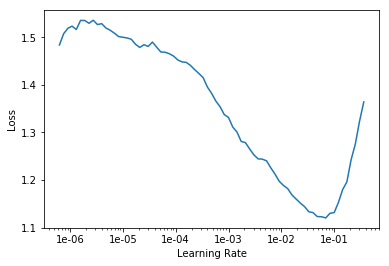

In [14]:
learn3.lr_find()
learn3.recorder.plot()

In [15]:
learn3.fit_one_cycle(10, slice(1e-3, 1e-2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


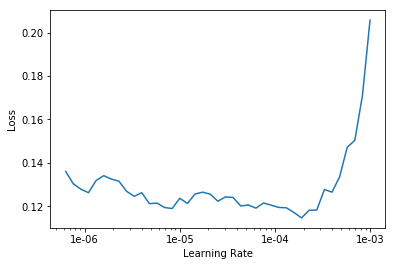

In [16]:
learn3.unfreeze()
learn3.lr_find()
learn3.recorder.plot()

In [17]:
learn3.fit_one_cycle(8, slice(1e-5, 1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


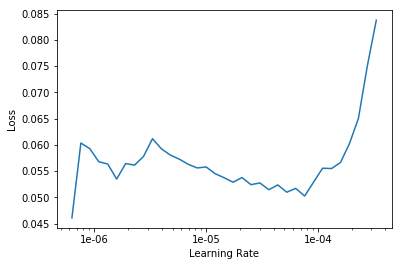

In [18]:
learn3.unfreeze()
learn3.lr_find()
learn3.recorder.plot()

In [19]:
learn3.fit_one_cycle(8, slice(1e-5, 1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


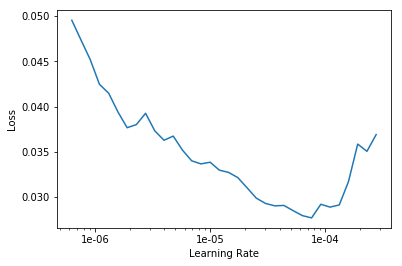

In [20]:
learn3.unfreeze()
learn3.lr_find()
learn3.recorder.plot()

In [21]:
learn3.fit_one_cycle(8, slice(1e-6, 1e-5))

In [22]:
log_preds, y = learn3.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.8187)